# -----------------Take-Home Assignment-----------------



*   This trades are made with microseconds speed and we want to be sure that we trade continuously and our expectations from strategies are met by real market data
*   TODO: Read the data from the file, examine it, perform simple statistical analysis, and conduct A/B testing of trading strategies



# -----------------Data exploration-----------------



*   Download the dataset from Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import pandas as pd

zip_path = '/content/drive/MyDrive/Colab Notebooks/sparkland/orders.csv.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

df = pd.read_csv('/content/orders.csv')
# df = pd.read_csv('/content/orders.csv', nrows=50000)

*   Initial EDA

In [3]:
df.describe(include='all')

,id,timestamp,market,pair,side,quantity,price,order_type,execution_time
count,4.290032e+07,4.290032e+07,42900318,42900318,42900318,4.290032e+07,4.290032e+07,42900318,4.290032e+07
unique,NaN,NaN,3,5,2,NaN,NaN,2,NaN
top,NaN,NaN,BINANCE,BTC_USDT,BID,NaN,NaN,Limit,NaN
freq,NaN,NaN,14305616,8583094,21452023,NaN,NaN,21452820,NaN
mean,2.145016e+07,1.733043e+15,NaN,NaN,NaN,5.004428e-01,5.000448e+02,NaN,5.068667e+00
std,1.238426e+07,2.493128e+10,NaN,NaN,NaN,2.883960e-01,2.886483e+02,NaN,5.900863e+00
min,1.000000e+00,1.733000e+15,NaN,NaN,NaN,1.000000e-03,1.000000e-01,NaN,1.000000e-01
25%,1.072508e+07,1.733022e+15,NaN,NaN,NaN,2.510000e-01,2.500447e+02,NaN,2.576000e+00
50%,2.145016e+07,1.733043e+15,NaN,NaN,NaN,5.000000e-01,5.000942e+02,NaN,5.052000e+00
75%,3.217524e+07,1.733065e+15,NaN,NaN,NaN,7.500000e-01,7.500758e+02,NaN,7.528000e+00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42900318 entries, 0 to 42900317
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   timestamp       int64  
 2   market          object 
 3   pair            object 
 4   side            object 
 5   quantity        float64
 6   price           float64
 7   order_type      object 
 8   execution_time  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.9+ GB


In [5]:
df['trade_value'] = df['quantity'] * df['price']

*   Find data loss periods if any



In [6]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='us') #setting unit to microsecond

In [7]:
df['gap'] = df['datetime'].diff().dt.total_seconds()

In [8]:
# View rows where the gap exceeds 10 micro sec
gap_threshold = 10
data_gaps = df[df['gap'] > gap_threshold]
data_gaps

,id,timestamp,market,pair,side,quantity,price,order_type,execution_time,trade_value,datetime,gap


# -----------------Statistical Analysis-----------------



*   Identify any outliers in trade quantity or execution times

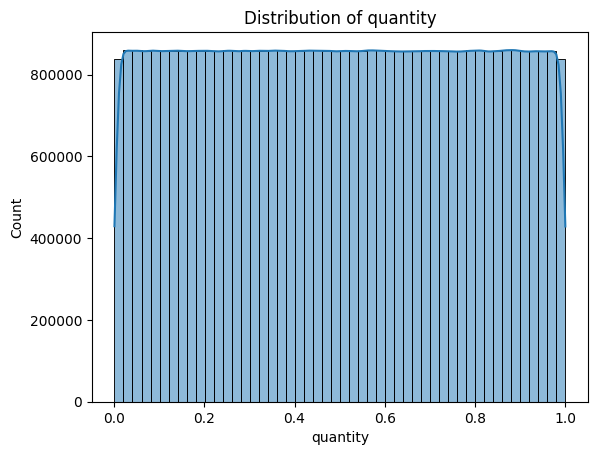

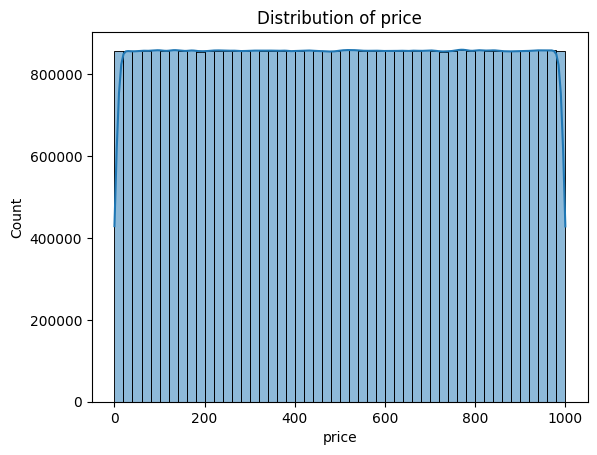

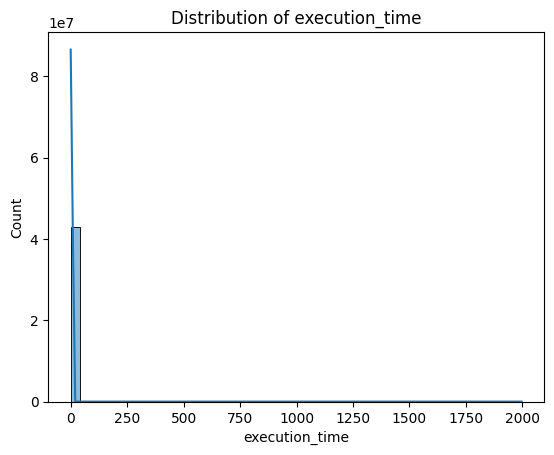

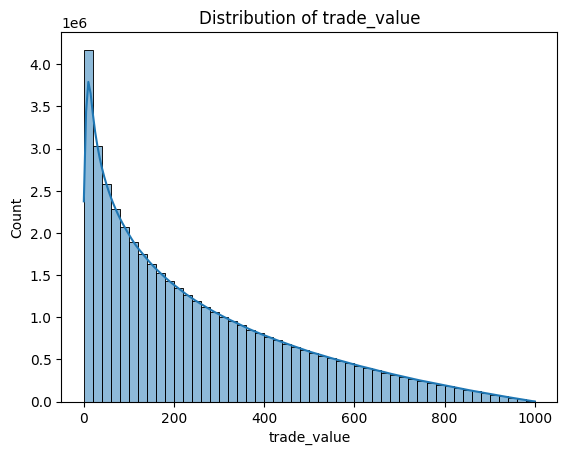

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ['quantity', 'price', 'execution_time', 'trade_value']
for col in numerical_cols:
    plt.figure()
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')


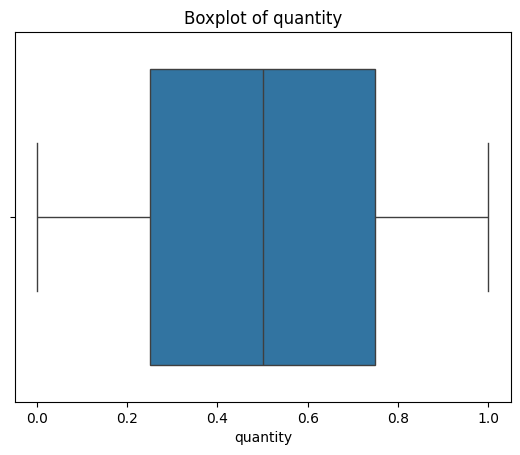

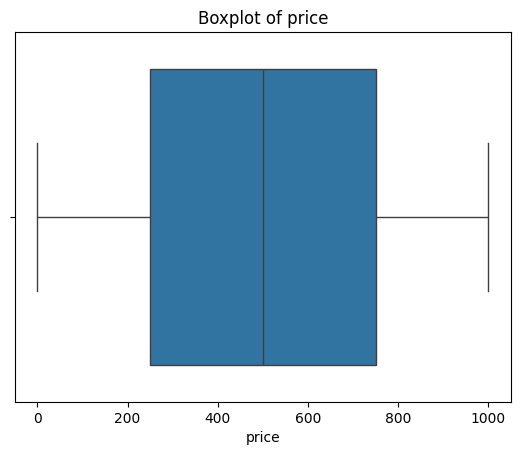

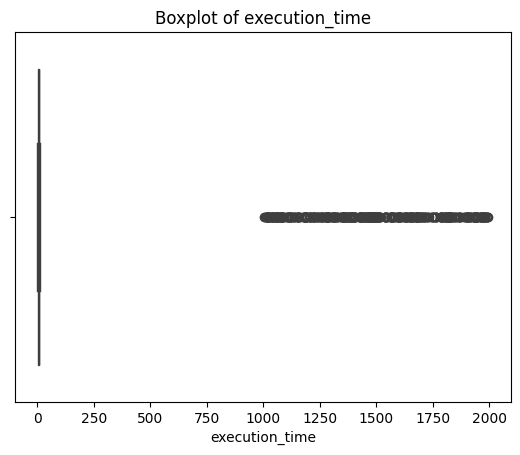

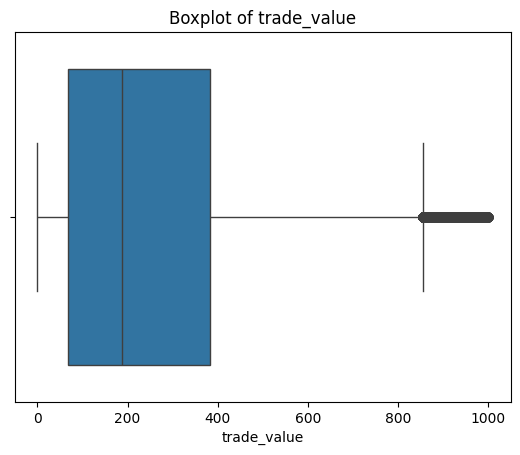

In [10]:
for col in numerical_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

*   Compute the average trade quantity


In [11]:
avg_quantity = df.groupby('market')['quantity'].mean().sort_values(ascending=False)
print(avg_quantity)


market
HUOBI      0.500477
KRAKEN     0.500469
BINANCE    0.500383
Name: quantity, dtype: float64


*   Removing outliers

In [12]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.8 * IQR
    upper = Q3 + 1.8 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

df_clean = remove_outliers_iqr(df, 'execution_time')


In [13]:
min_date = df_clean['datetime'].min()
max_date = df_clean['datetime'].max()

print("📅 Earliest datetime:", min_date)
print("📅 Latest datetime:  ", max_date)

📅 Earliest datetime: 2024-11-30 21:00:00.000165
📅 Latest datetime:   2024-12-01 20:59:59.263626


*   Checking outliers have been removed

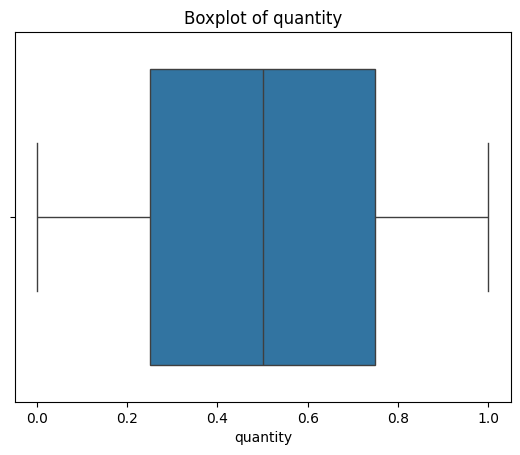

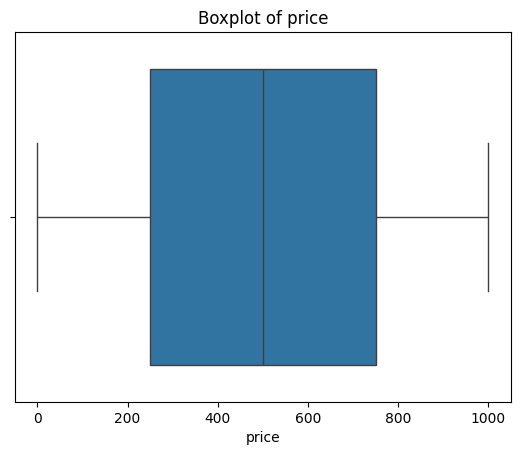

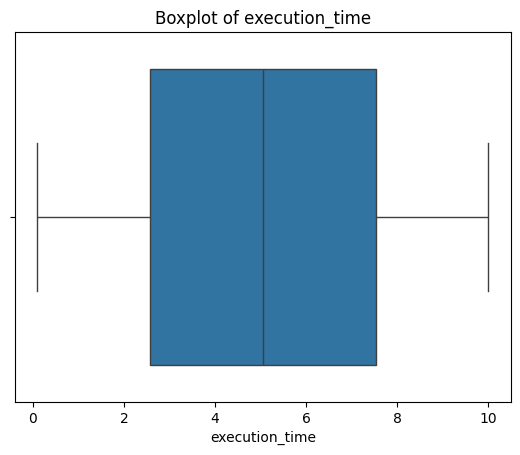

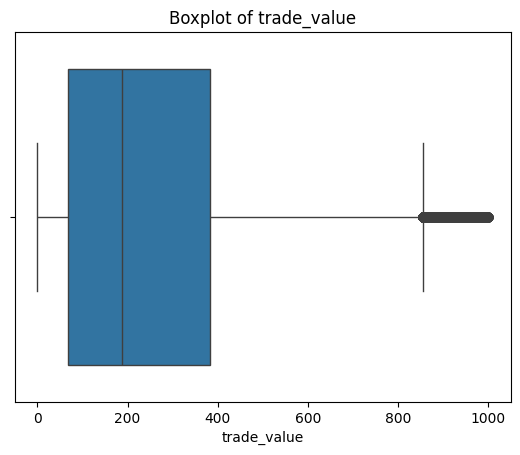

In [14]:
for col in numerical_cols:
    plt.figure()
    sns.boxplot(x=df_clean[col])
    plt.title(f'Boxplot of {col}')

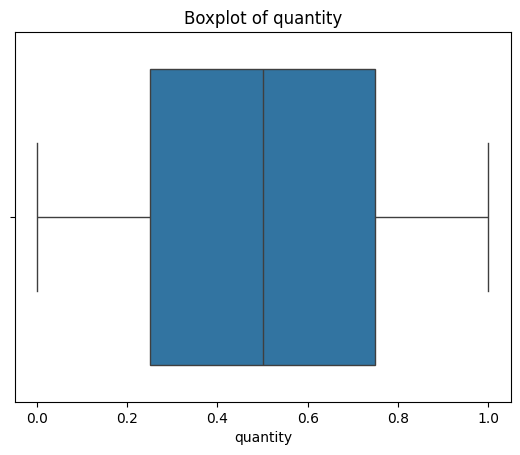

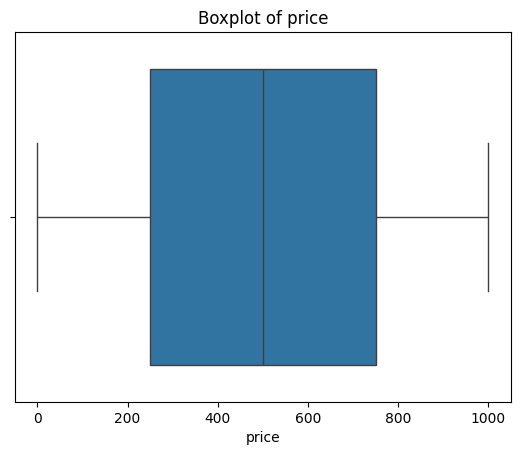

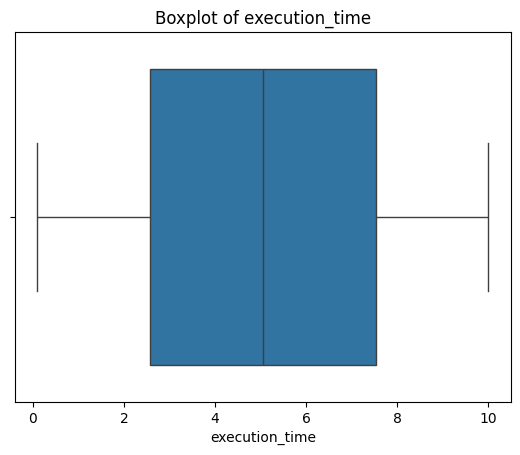

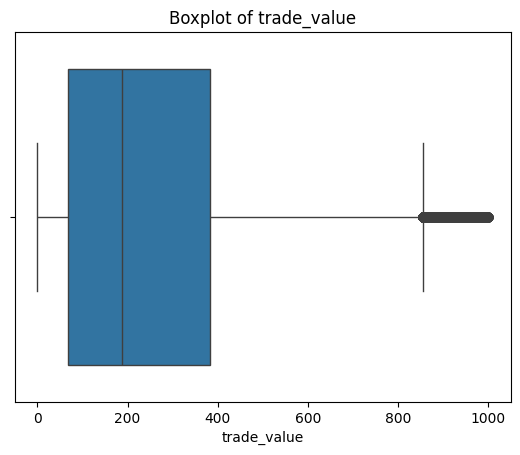

In [15]:
for col in numerical_cols:
    plt.figure()
    sns.boxplot(x=df_clean[col])
    plt.title(f'Boxplot of {col}')

*   Distribution of execution time per market


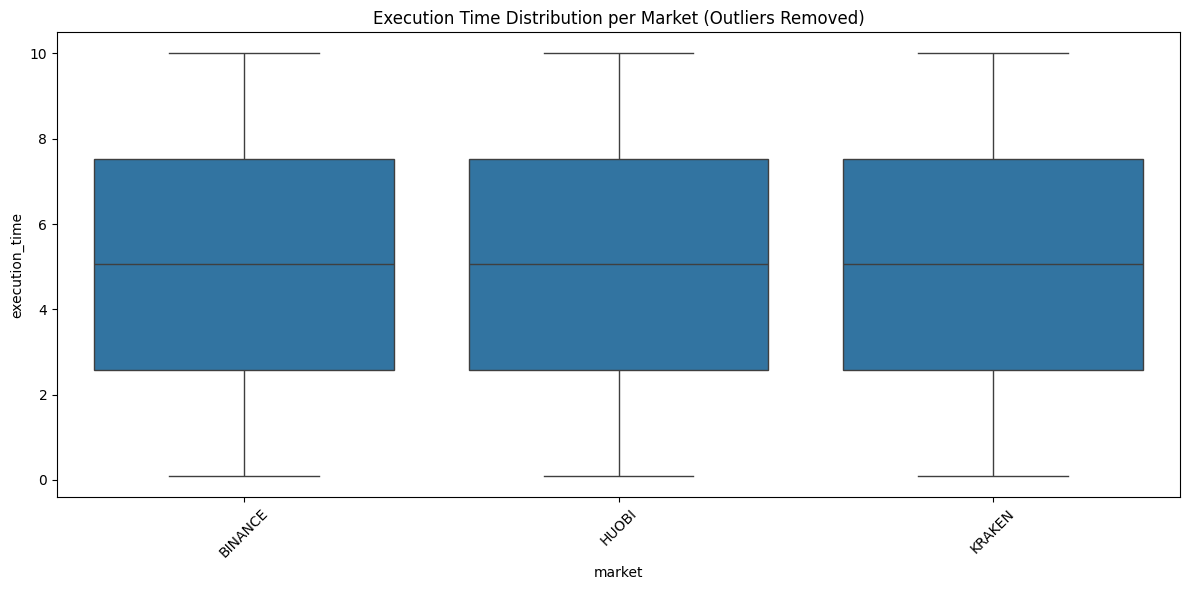

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='market', y='execution_time')
plt.title("Execution Time Distribution per Market (Outliers Removed)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


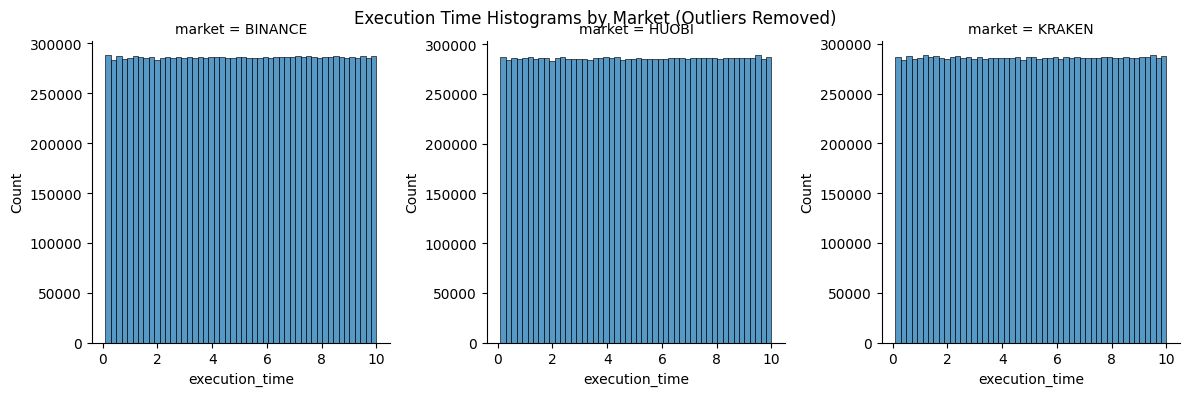

In [17]:
g = sns.FacetGrid(df_clean, col="market", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "execution_time", bins=50)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Execution Time Histograms by Market (Outliers Removed)")
plt.show()


*   Process trade data to aggregate 10-minute OHLC

In [18]:
ohlc_dict = {
    'price': ['first', 'max', 'min', 'last'],
    'quantity': 'sum'
}

In [19]:
ohlcv = (
    df_clean
    .set_index('datetime')
    .sort_index()
    .groupby(['market', 'pair'])  # group by each trading pair per market
    .resample('10T')  # 10-minute intervals
    .agg(ohlc_dict)
    .dropna()
)

/tmp/ipython-input-19-816496220.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('10T')  # 10-minute intervals


In [20]:
ohlcv.columns = ['open', 'high', 'low', 'close', 'volume']
ohlcv = ohlcv.reset_index()

In [21]:
data = ohlcv[(ohlcv['market'] == 'BINANCE') & (ohlcv['pair'] == 'ETH_USDT')]
data

,market,pair,datetime,open,high,low,close,volume
288,BINANCE,ETH_USDT,2024-11-30 21:00:00,368.4531,999.9864,0.1199,951.1307,10045.993
289,BINANCE,ETH_USDT,2024-11-30 21:10:00,29.9783,999.9961,0.1080,532.7673,10001.200
290,BINANCE,ETH_USDT,2024-11-30 21:20:00,985.0789,999.8416,0.1446,613.0493,9964.182
291,BINANCE,ETH_USDT,2024-11-30 21:30:00,277.0598,999.9798,0.1101,510.8065,10041.724
292,BINANCE,ETH_USDT,2024-11-30 21:40:00,631.6377,999.9360,0.1474,356.8953,10012.376
...,...,...,...,...,...,...,...,...
427,BINANCE,ETH_USDT,2024-12-01 20:10:00,611.3593,999.9942,0.1222,631.5929,9970.632
428,BINANCE,ETH_USDT,2024-12-01 20:20:00,572.9527,999.9998,0.1204,236.4205,9957.726
429,BINANCE,ETH_USDT,2024-12-01 20:30:00,721.9061,999.9094,0.1098,105.9721,9905.702
430,BINANCE,ETH_USDT,2024-12-01 20:40:00,522.6779,999.9632,0.1378,433.2063,9986.070


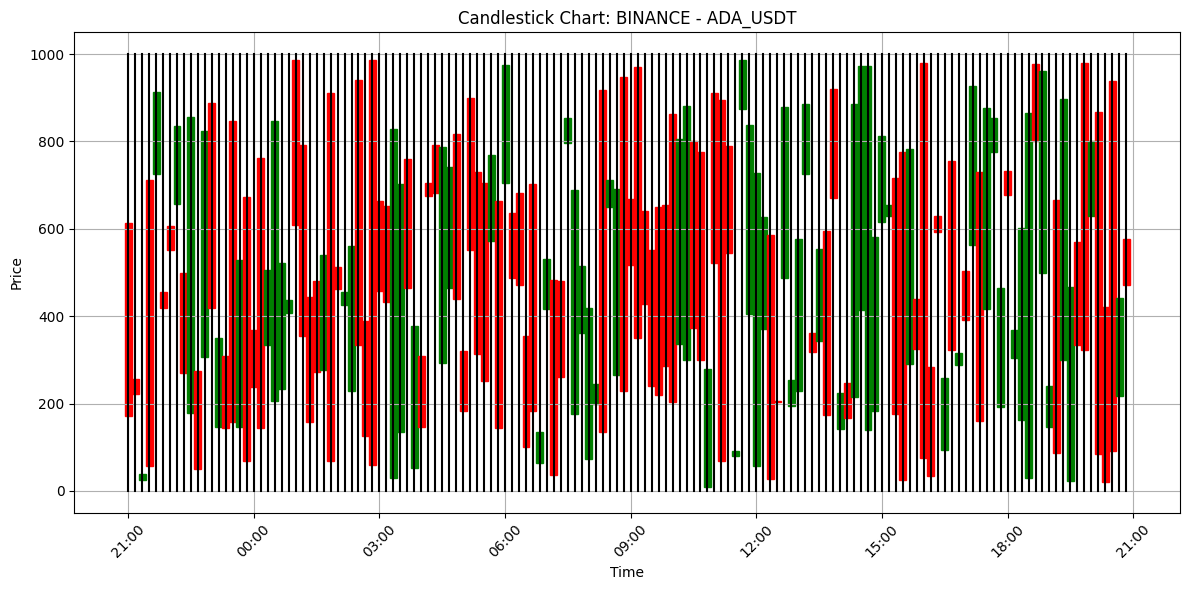

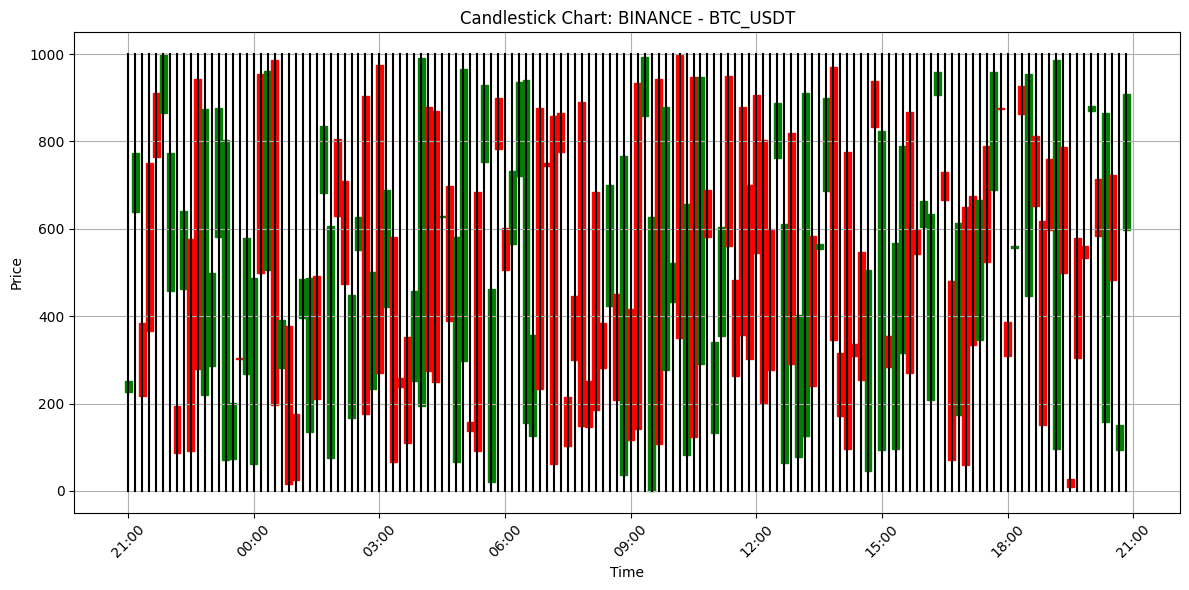

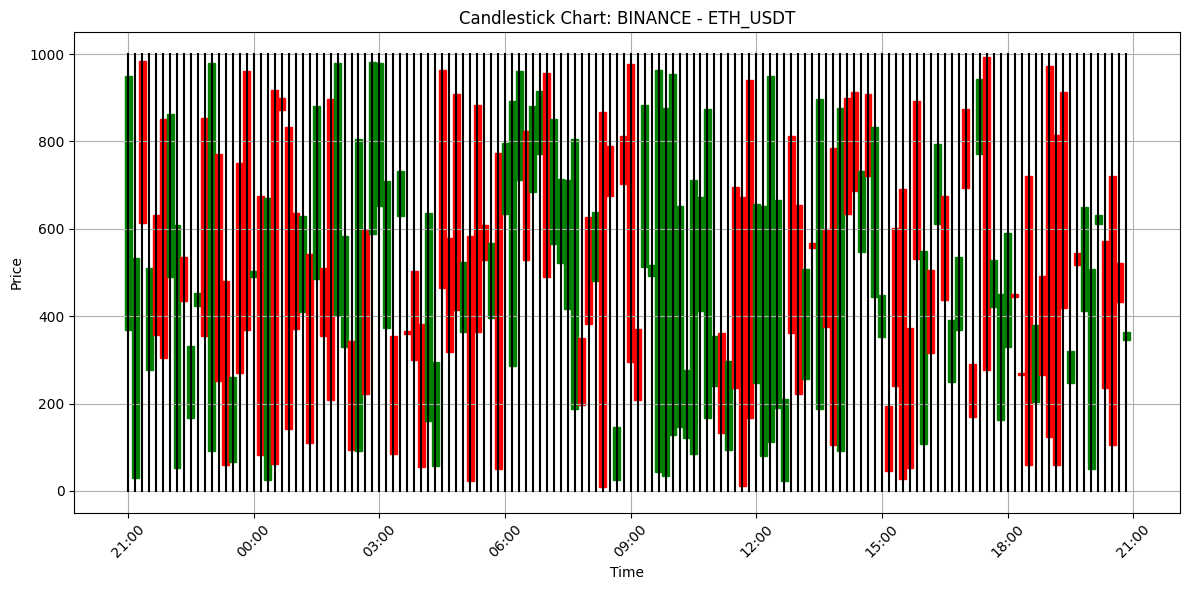

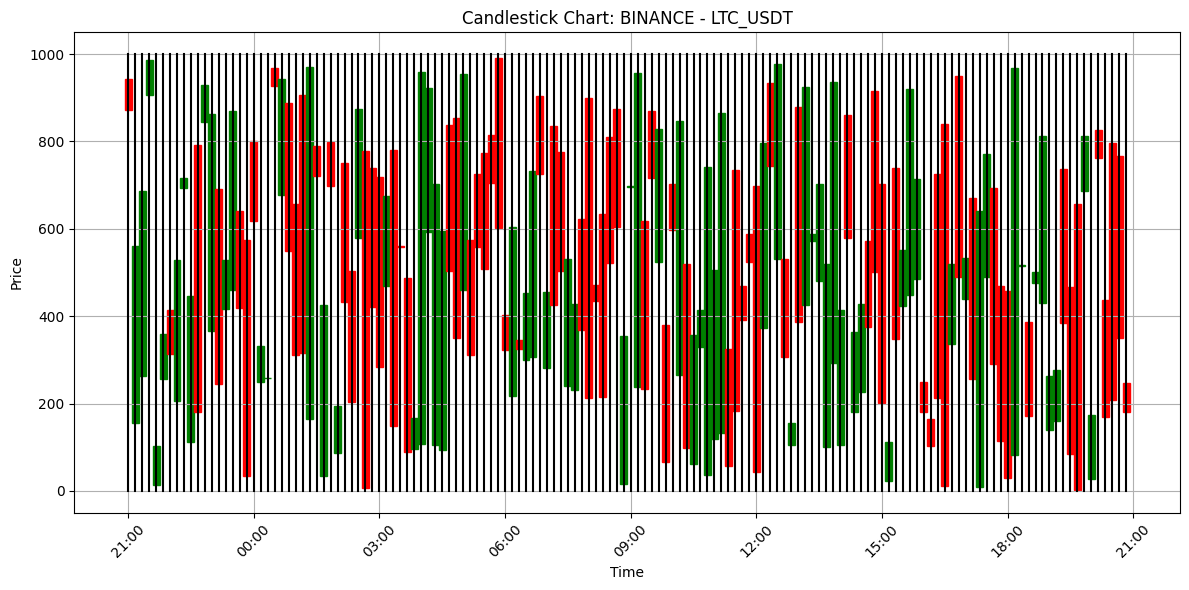

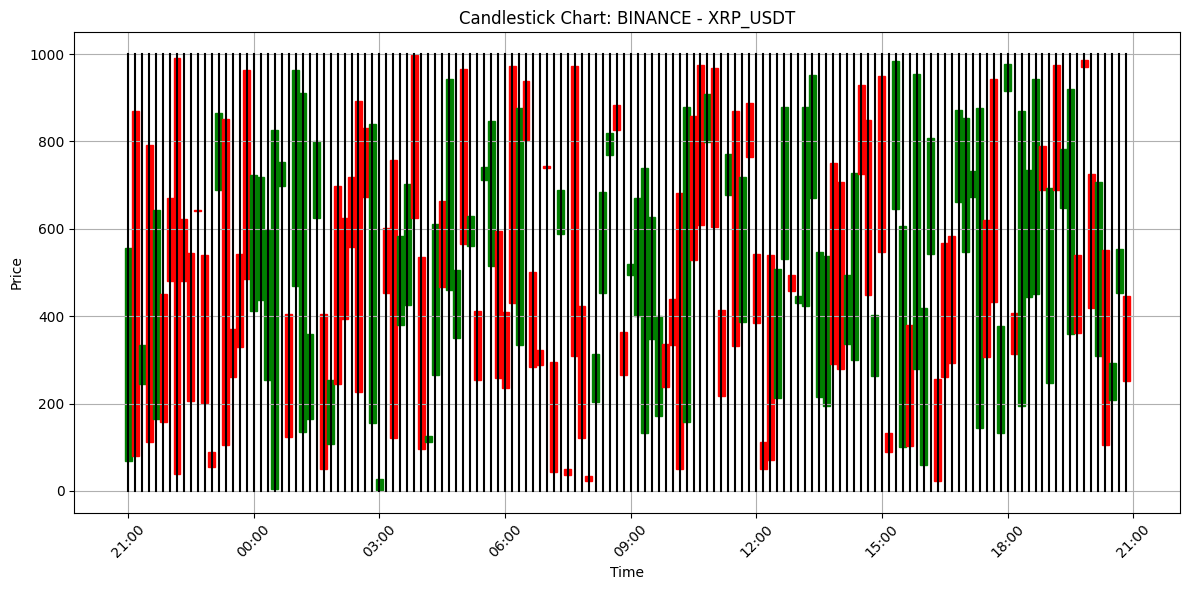

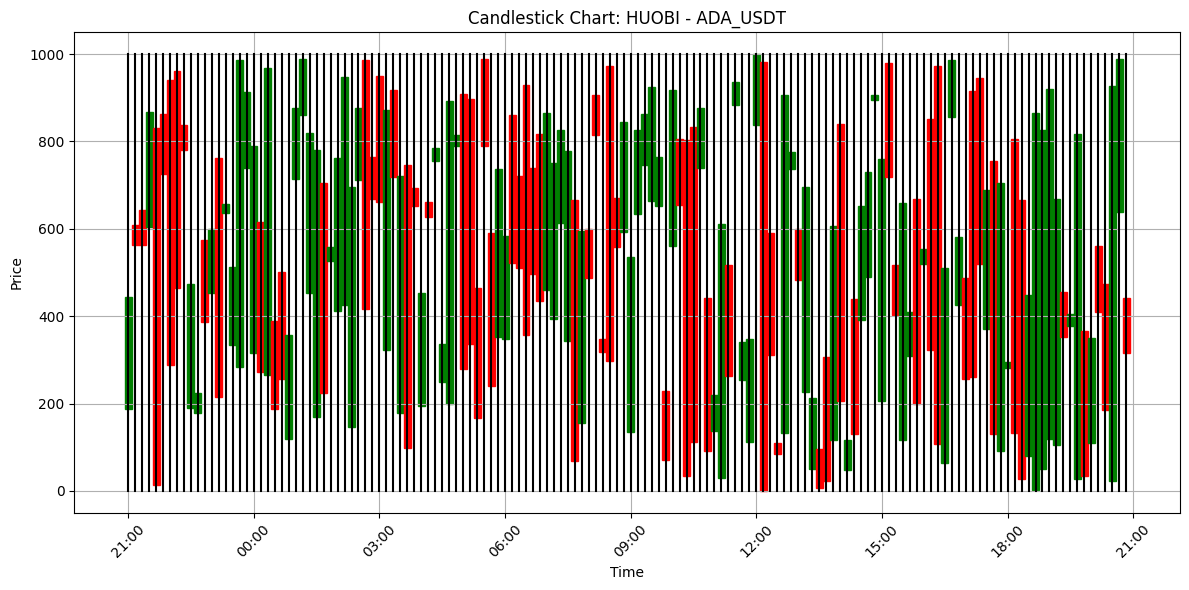

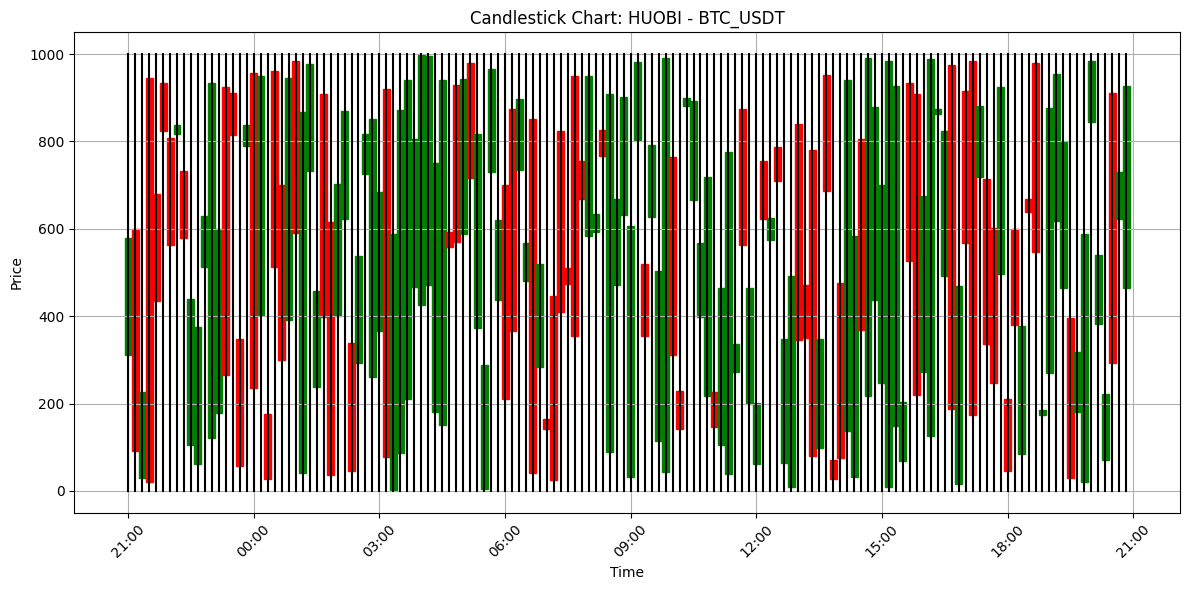

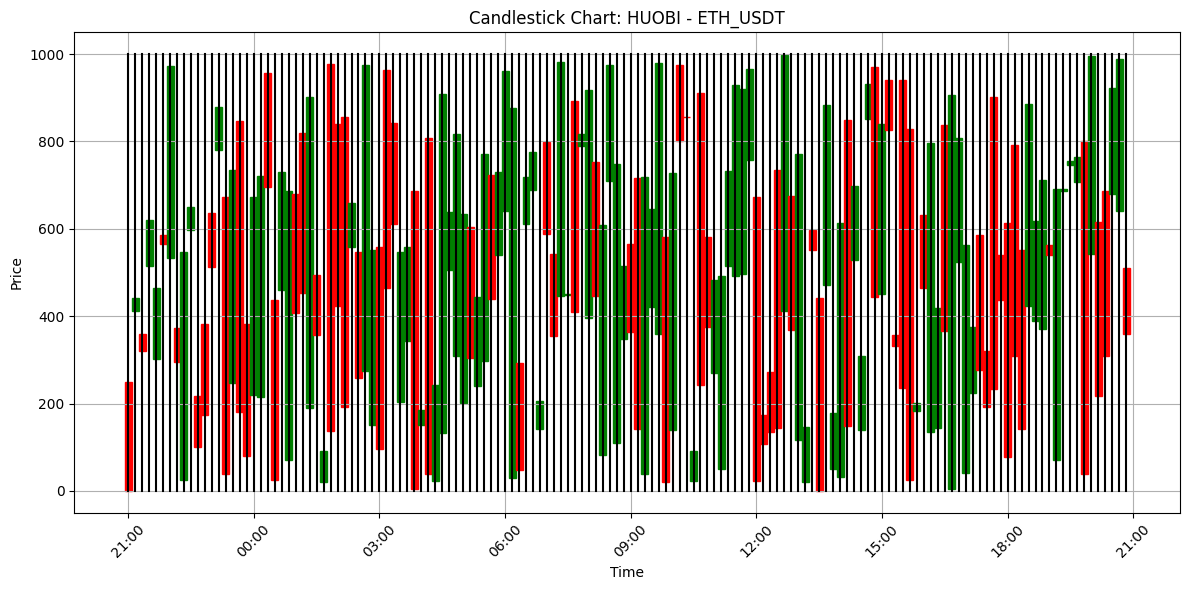

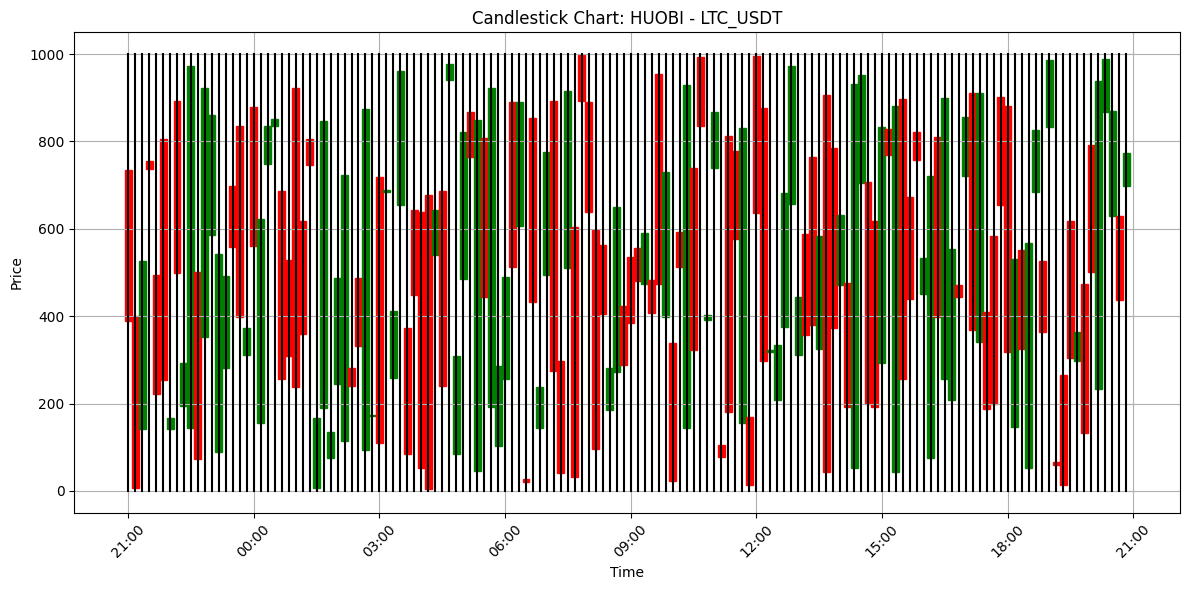

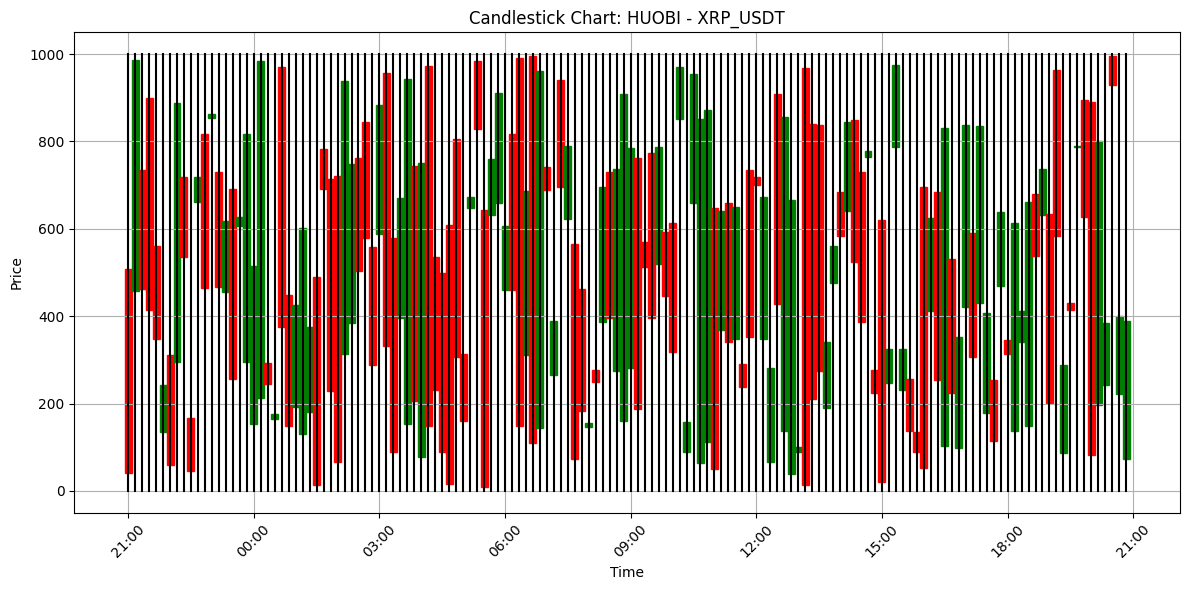

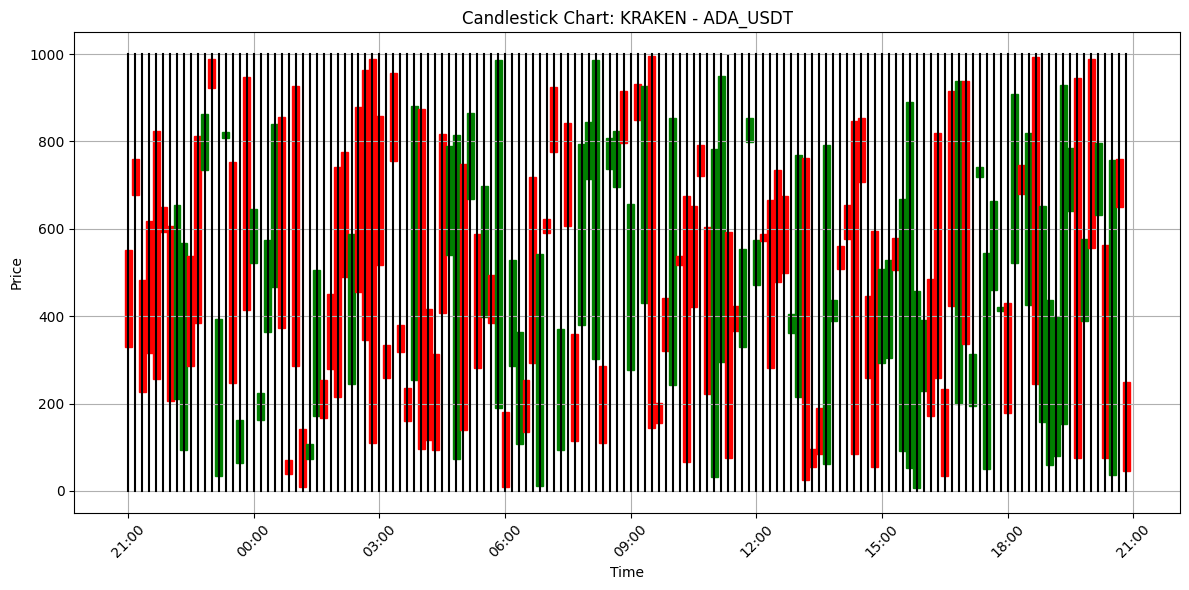

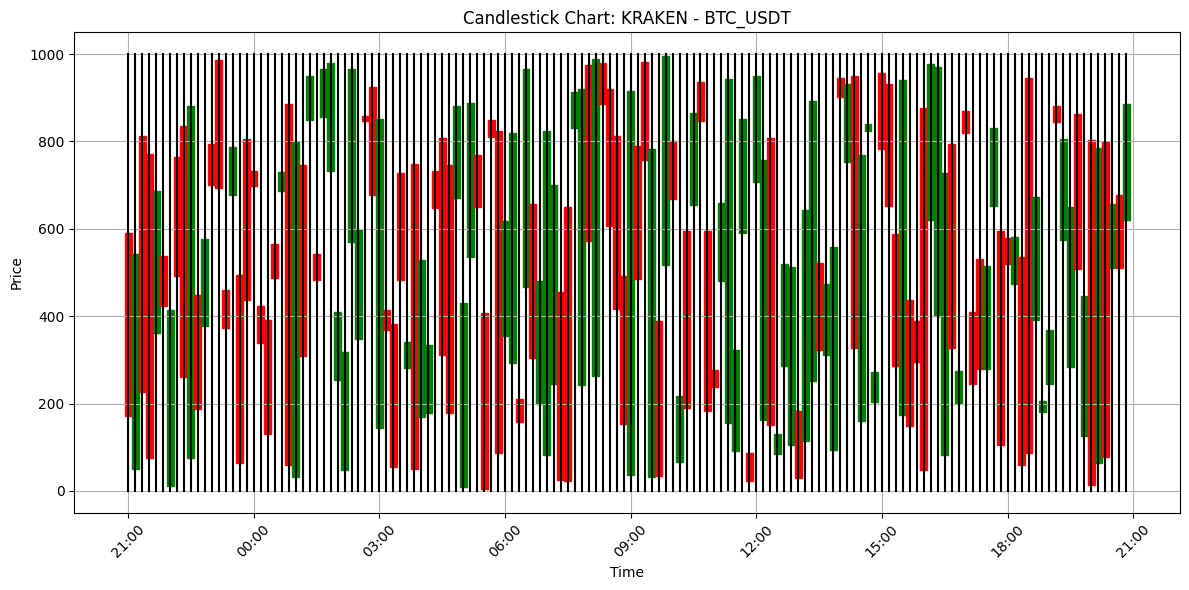

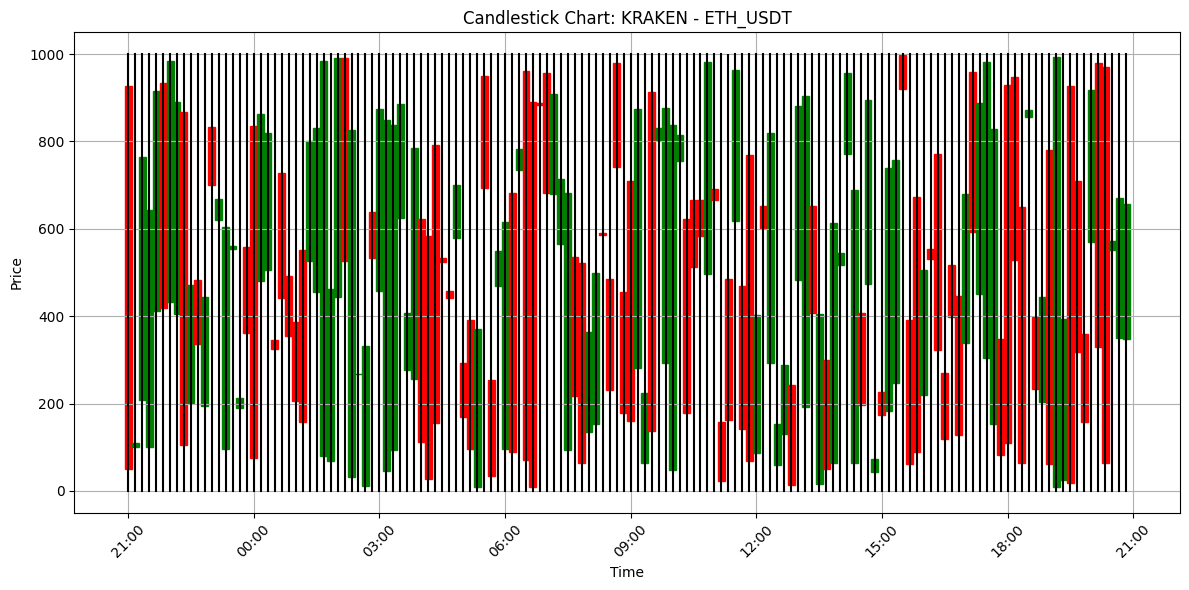

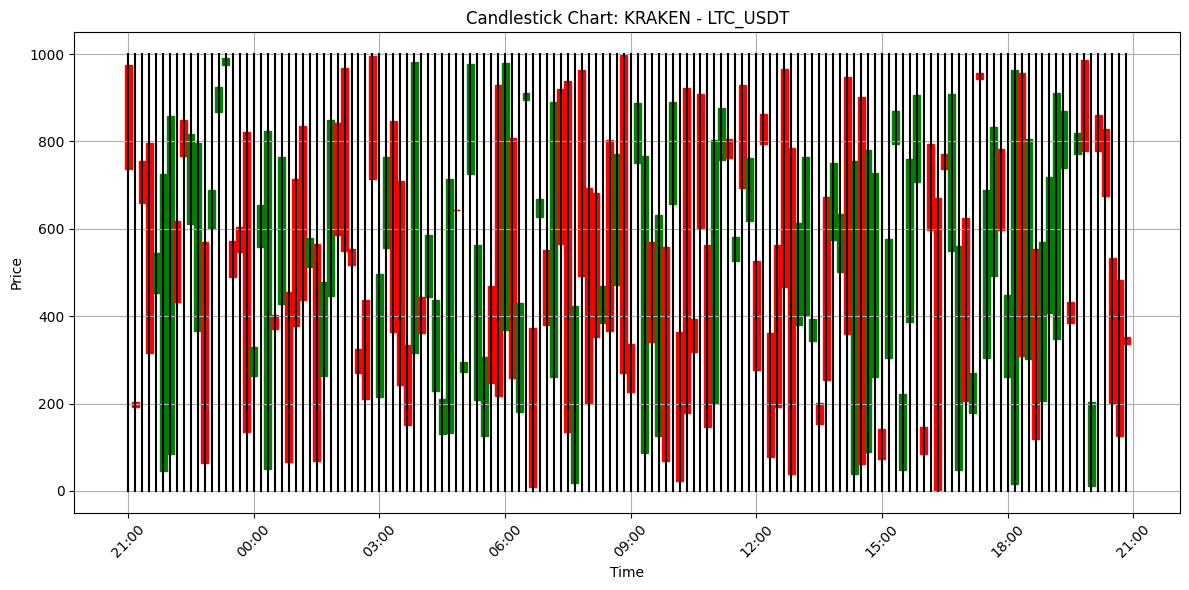

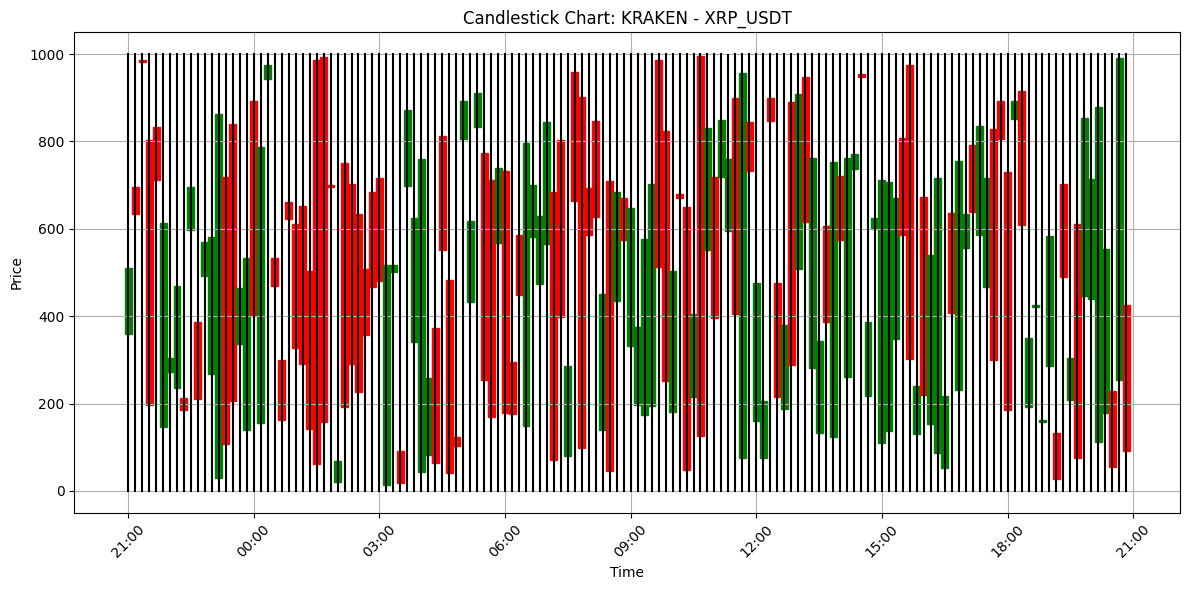

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

# Loop through all unique (market, pair) groups
for (market, pair), pair_df in ohlcv.groupby(['market', 'pair']):
    fig, ax = plt.subplots(figsize=(12, 6))

    pair_df = pair_df.sort_values('datetime').copy()
    pair_df['date_num'] = mdates.date2num(pair_df['datetime'])

    width = 10 / (24*60)

    for idx, row in pair_df.iterrows():
        color = 'green' if row['close'] >= row['open'] else 'red'
        lower = min(row['open'], row['close'])
        height = abs(row['close'] - row['open'])

        # Candle body
        ax.add_patch(Rectangle((row['date_num'] - width/2, lower), width, height, color=color))

        # High-low wick
        ax.plot([row['date_num'], row['date_num']], [row['low'], row['high']], color='black')

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    plt.title(f'Candlestick Chart: {market} - {pair}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# -----------------A/B Testing-----------------



*   We have a hypothesis that "Market orders result in faster executions compared to limit orders"

In [23]:
import pandas as pd
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Market and limit data
market_exec = df_clean[df_clean['order_type'] == 'Market']['execution_time']
limit_exec = df_clean[df_clean['order_type'] == 'Limit']['execution_time']

print("Market Median:", market_exec.median())
print("Limit Median: ", limit_exec.median())


Market Median: 5.053
Limit Median:  5.051


*   Visualization for whole dataset

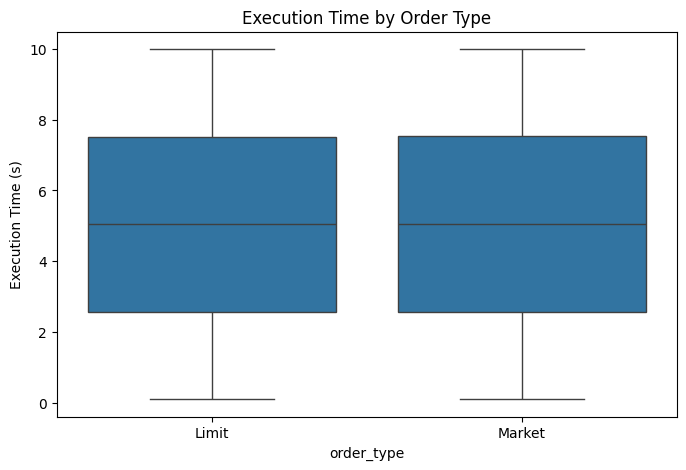

Mann-Whitney U test p-value: 0.18882019653540594


In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clean, x='order_type', y='execution_time')
plt.title("Execution Time by Order Type")
plt.ylabel("Execution Time (s)")
plt.show()

# Mann-Whitney U Test
stat, p = mannwhitneyu(market_exec, limit_exec, alternative='two-sided')
print("Mann-Whitney U test p-value:", p)


In [25]:
# WITH ALPHA 0.05
alpha = 0.05
if p < alpha:
    print("Reject null hypothesis: Statistically significant")
else:
    print("Fail to reject null hypothesis: Not Statistically significant")

Fail to reject null hypothesis: Not Statistically significant


*   Visualization for each market-pair combination

Testing for: BINANCE — ADA_USDT
Market Median: 5.056
Limit Median:  5.047


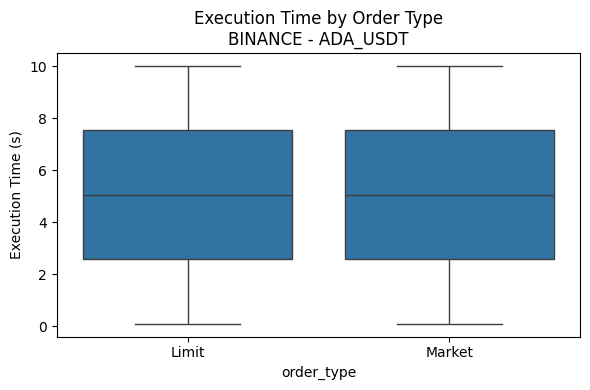

Mann-Whitney U test p-value: 0.11762
Fail to reject null hypothesis: Not Statistically significant
Testing for: BINANCE — BTC_USDT
Market Median: 5.053
Limit Median:  5.054


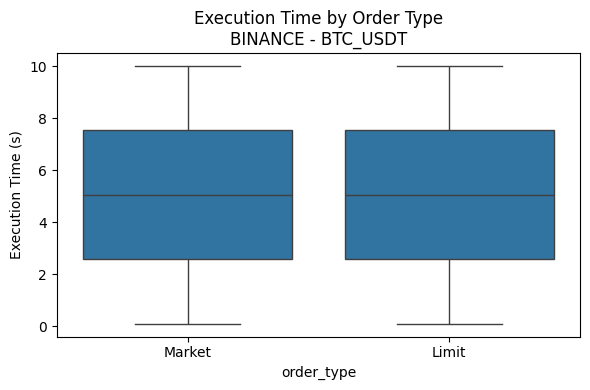

Mann-Whitney U test p-value: 0.53459
Fail to reject null hypothesis: Not Statistically significant
Testing for: BINANCE — ETH_USDT
Market Median: 5.056
Limit Median:  5.048


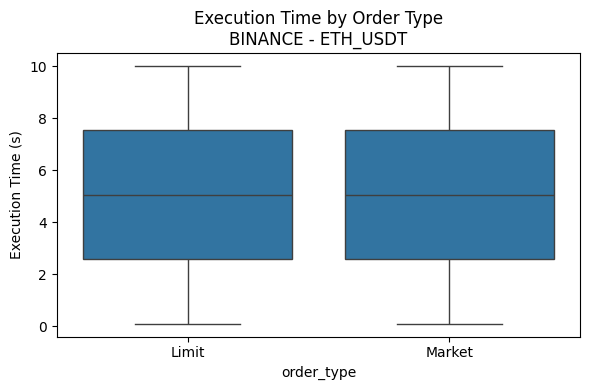

Mann-Whitney U test p-value: 0.39991
Fail to reject null hypothesis: Not Statistically significant
Testing for: BINANCE — LTC_USDT
Market Median: 5.057
Limit Median:  5.051


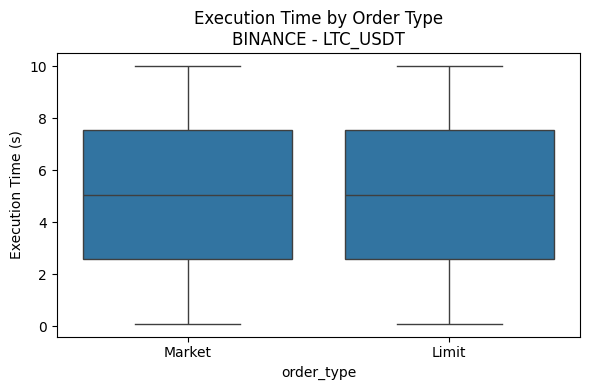

Mann-Whitney U test p-value: 0.94525
Fail to reject null hypothesis: Not Statistically significant
Testing for: BINANCE — XRP_USDT
Market Median: 5.053
Limit Median:  5.051


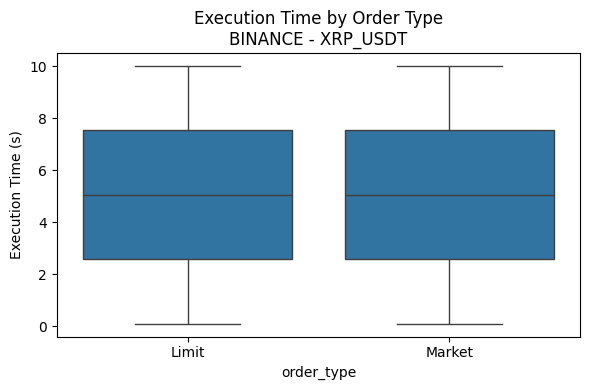

Mann-Whitney U test p-value: 0.992
Fail to reject null hypothesis: Not Statistically significant
Testing for: HUOBI — ADA_USDT
Market Median: 5.058
Limit Median:  5.052


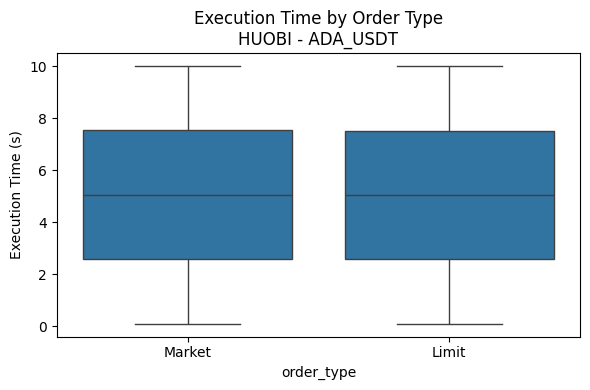

Mann-Whitney U test p-value: 0.16498
Fail to reject null hypothesis: Not Statistically significant
Testing for: HUOBI — BTC_USDT
Market Median: 5.052
Limit Median:  5.048


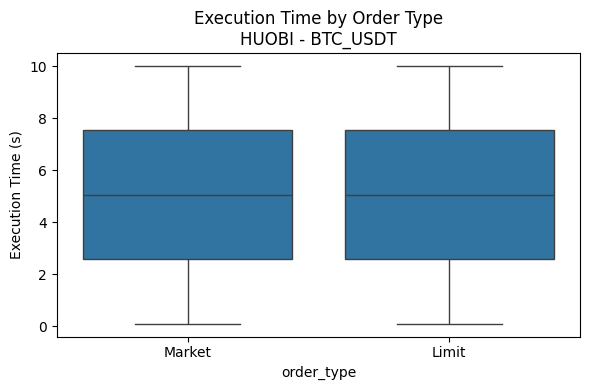

Mann-Whitney U test p-value: 0.43878
Fail to reject null hypothesis: Not Statistically significant
Testing for: HUOBI — ETH_USDT
Market Median: 5.052
Limit Median:  5.053


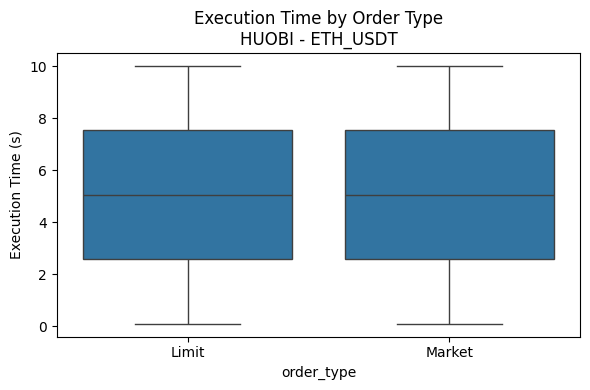

Mann-Whitney U test p-value: 0.56301
Fail to reject null hypothesis: Not Statistically significant
Testing for: HUOBI — LTC_USDT
Market Median: 5.051
Limit Median:  5.053


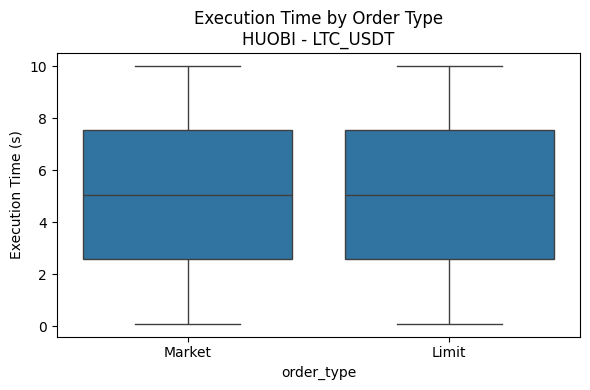

Mann-Whitney U test p-value: 0.5951
Fail to reject null hypothesis: Not Statistically significant
Testing for: HUOBI — XRP_USDT
Market Median: 5.06
Limit Median:  5.048


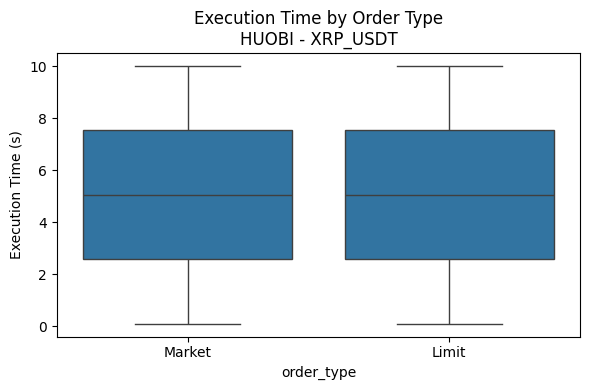

Mann-Whitney U test p-value: 0.28478
Fail to reject null hypothesis: Not Statistically significant
Testing for: KRAKEN — ADA_USDT
Market Median: 5.054
Limit Median:  5.054


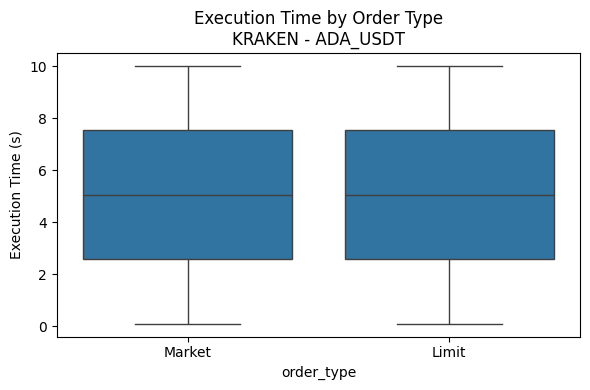

Mann-Whitney U test p-value: 0.66136
Fail to reject null hypothesis: Not Statistically significant
Testing for: KRAKEN — BTC_USDT
Market Median: 5.053
Limit Median:  5.055


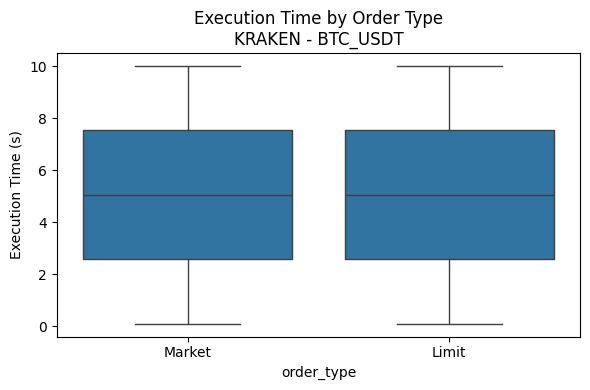

Mann-Whitney U test p-value: 0.70337
Fail to reject null hypothesis: Not Statistically significant
Testing for: KRAKEN — ETH_USDT
Market Median: 5.049
Limit Median:  5.049


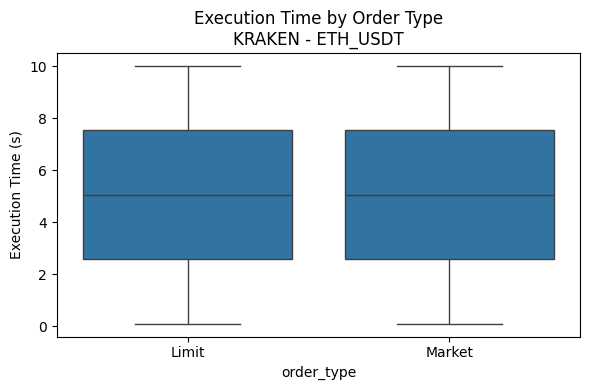

Mann-Whitney U test p-value: 0.59499
Fail to reject null hypothesis: Not Statistically significant
Testing for: KRAKEN — LTC_USDT
Market Median: 5.051
Limit Median:  5.044


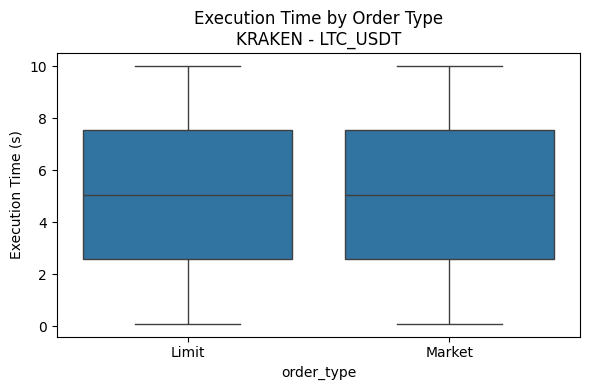

Mann-Whitney U test p-value: 0.69041
Fail to reject null hypothesis: Not Statistically significant
Testing for: KRAKEN — XRP_USDT
Market Median: 5.048
Limit Median:  5.051


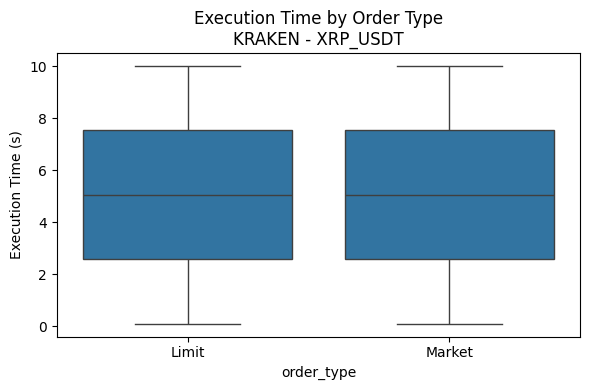

Mann-Whitney U test p-value: 0.89142
Fail to reject null hypothesis: Not Statistically significant


In [26]:
# Loop over each market–pair=
for (market, pair), group_df in df_clean.groupby(['market', 'pair']):
    print(f"Testing for: {market} — {pair}")

    # Subsets
    market_exec = group_df[group_df['order_type'] == 'Market']['execution_time']
    limit_exec = group_df[group_df['order_type'] == 'Limit']['execution_time']

    if len(market_exec) < 5 or len(limit_exec) < 5:
        continue

    print("Market Median:", round(market_exec.median(), 3))
    print("Limit Median: ", round(limit_exec.median(), 3))

    # Plotting
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=group_df, x='order_type', y='execution_time')
    plt.title(f"Execution Time by Order Type\n{market} - {pair}")
    plt.ylabel("Execution Time (s)")
    plt.tight_layout()
    plt.show()

    # Mann-Whitney U Test
    stat, p = mannwhitneyu(market_exec, limit_exec, alternative='two-sided')
    print("Mann-Whitney U test p-value:", round(p, 5))

    alpha = 0.05
    if p < alpha:
        print("Reject null hypothesis: Statistically significant")
    else:
        print("Fail to reject null hypothesis: Not Statistically significant")


*   Visualization for each market-pair combination:For Kolmogorov-Smirnov Test

KS Test for: BINANCE — ADA_USDT
Market Median: 5.056
Limit Median:  5.047


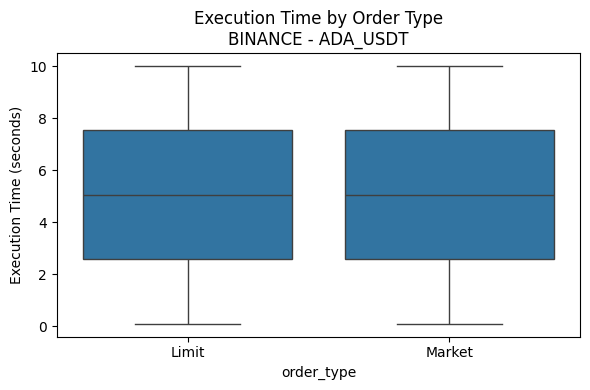

Kolmogorov-Smirnov test statistic: 0.00123
Kolmogorov-Smirnov p-value: 0.22659
Fail to reject null hypothesis: Not Statistically significant
KS Test for: BINANCE — BTC_USDT
Market Median: 5.053
Limit Median:  5.054


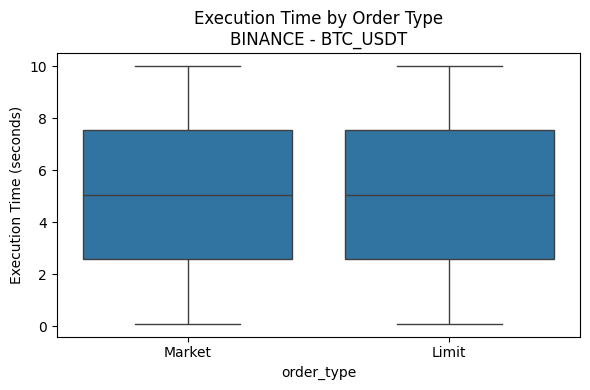

Kolmogorov-Smirnov test statistic: 0.0007
Kolmogorov-Smirnov p-value: 0.87262
Fail to reject null hypothesis: Not Statistically significant
KS Test for: BINANCE — ETH_USDT
Market Median: 5.056
Limit Median:  5.048


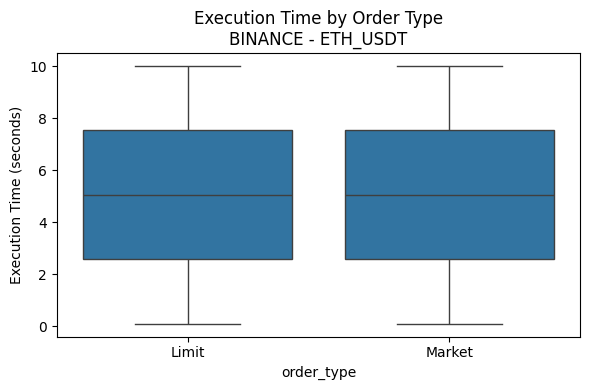

Kolmogorov-Smirnov test statistic: 0.00115
Kolmogorov-Smirnov p-value: 0.29609
Fail to reject null hypothesis: Not Statistically significant
KS Test for: BINANCE — LTC_USDT
Market Median: 5.057
Limit Median:  5.051


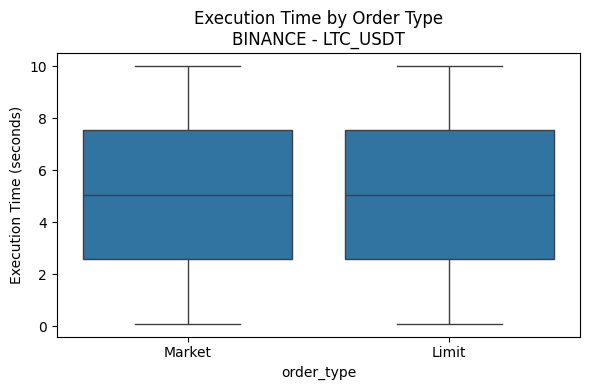

Kolmogorov-Smirnov test statistic: 0.00086
Kolmogorov-Smirnov p-value: 0.66901
Fail to reject null hypothesis: Not Statistically significant
KS Test for: BINANCE — XRP_USDT
Market Median: 5.053
Limit Median:  5.051


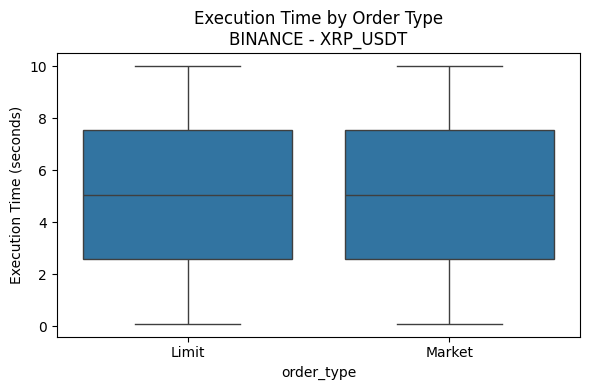

Kolmogorov-Smirnov test statistic: 0.00055
Kolmogorov-Smirnov p-value: 0.98232
Fail to reject null hypothesis: Not Statistically significant
KS Test for: HUOBI — ADA_USDT
Market Median: 5.058
Limit Median:  5.052


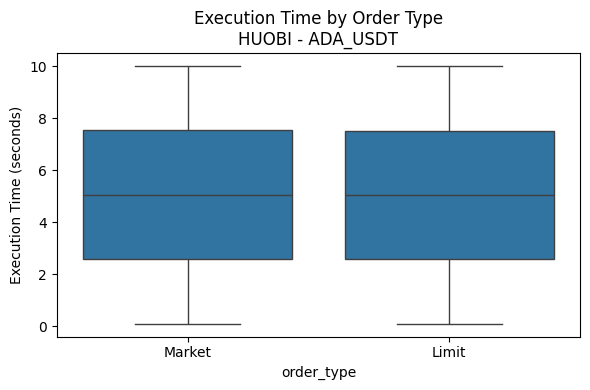

Kolmogorov-Smirnov test statistic: 0.00106
Kolmogorov-Smirnov p-value: 0.39403
Fail to reject null hypothesis: Not Statistically significant
KS Test for: HUOBI — BTC_USDT
Market Median: 5.052
Limit Median:  5.048


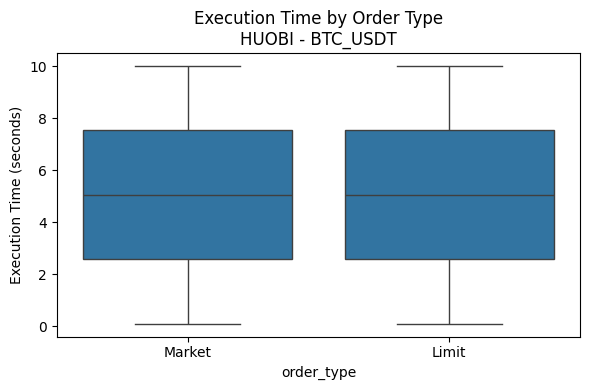

Kolmogorov-Smirnov test statistic: 0.00093
Kolmogorov-Smirnov p-value: 0.56577
Fail to reject null hypothesis: Not Statistically significant
KS Test for: HUOBI — ETH_USDT
Market Median: 5.052
Limit Median:  5.053


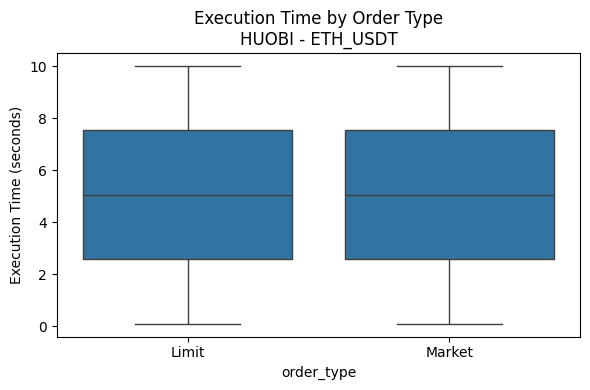

Kolmogorov-Smirnov test statistic: 0.00078
Kolmogorov-Smirnov p-value: 0.78126
Fail to reject null hypothesis: Not Statistically significant
KS Test for: HUOBI — LTC_USDT
Market Median: 5.051
Limit Median:  5.053


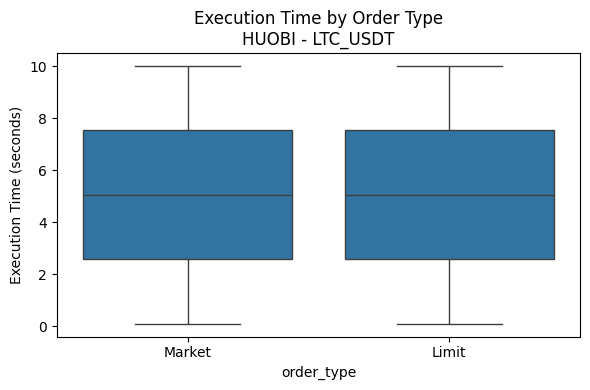

Kolmogorov-Smirnov test statistic: 0.00064
Kolmogorov-Smirnov p-value: 0.93062
Fail to reject null hypothesis: Not Statistically significant
KS Test for: HUOBI — XRP_USDT
Market Median: 5.06
Limit Median:  5.048


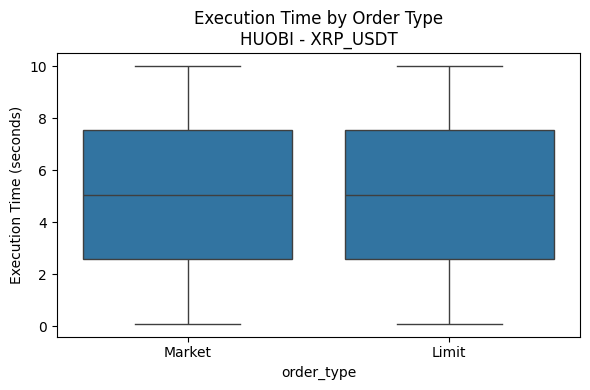

Kolmogorov-Smirnov test statistic: 0.00135
Kolmogorov-Smirnov p-value: 0.14819
Fail to reject null hypothesis: Not Statistically significant
KS Test for: KRAKEN — ADA_USDT
Market Median: 5.054
Limit Median:  5.054


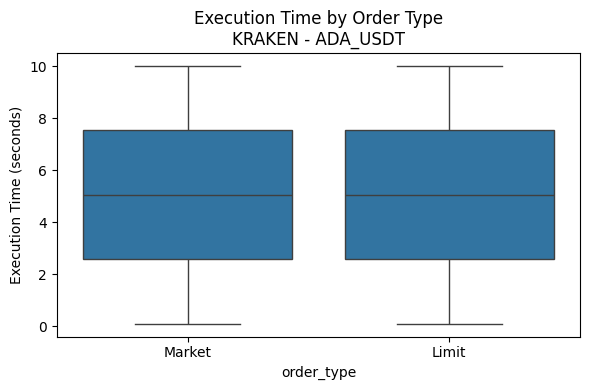

Kolmogorov-Smirnov test statistic: 0.00134
Kolmogorov-Smirnov p-value: 0.15025
Fail to reject null hypothesis: Not Statistically significant
KS Test for: KRAKEN — BTC_USDT
Market Median: 5.053
Limit Median:  5.055


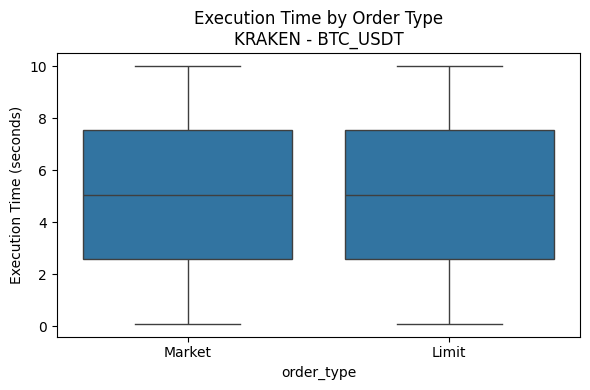

Kolmogorov-Smirnov test statistic: 0.00091
Kolmogorov-Smirnov p-value: 0.59339
Fail to reject null hypothesis: Not Statistically significant
KS Test for: KRAKEN — ETH_USDT
Market Median: 5.049
Limit Median:  5.049


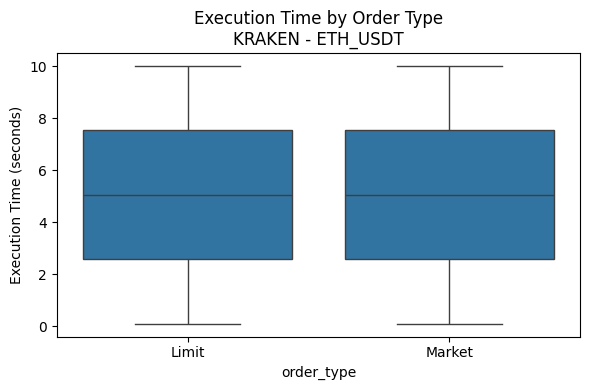

Kolmogorov-Smirnov test statistic: 0.00067
Kolmogorov-Smirnov p-value: 0.90615
Fail to reject null hypothesis: Not Statistically significant
KS Test for: KRAKEN — LTC_USDT
Market Median: 5.051
Limit Median:  5.044


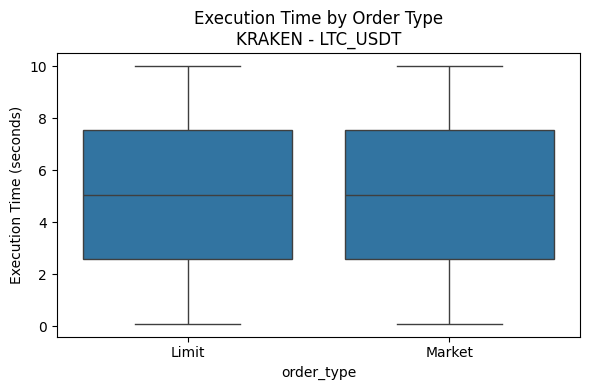

Kolmogorov-Smirnov test statistic: 0.00081
Kolmogorov-Smirnov p-value: 0.73719
Fail to reject null hypothesis: Not Statistically significant
KS Test for: KRAKEN — XRP_USDT
Market Median: 5.048
Limit Median:  5.051


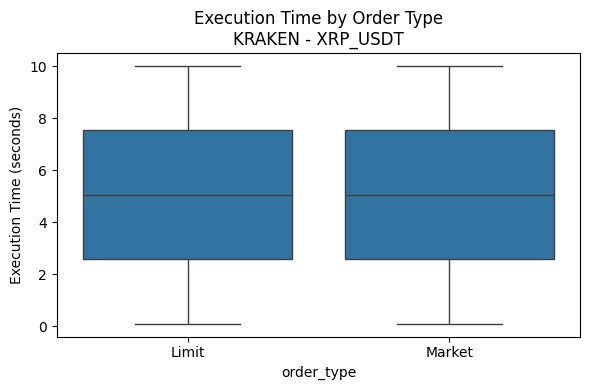

Kolmogorov-Smirnov test statistic: 0.00114
Kolmogorov-Smirnov p-value: 0.31153
Fail to reject null hypothesis: Not Statistically significant


In [27]:
import pandas as pd
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

for (market, pair), group_df in df_clean.groupby(['market', 'pair']):
    print(f"KS Test for: {market} — {pair}")

    market_exec = group_df[group_df['order_type'] == 'Market']['execution_time']
    limit_exec = group_df[group_df['order_type'] == 'Limit']['execution_time']

    if len(market_exec) < 5 or len(limit_exec) < 5:
        continue

    # Summary stats
    print("Market Median:", round(market_exec.median(), 3))
    print("Limit Median: ", round(limit_exec.median(), 3))

    # Plots
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=group_df, x='order_type', y='execution_time')
    plt.title(f"Execution Time by Order Type\n{market} - {pair}")
    plt.ylabel("Execution Time (seconds)")
    plt.tight_layout()
    plt.show()

    stat, p = ks_2samp(market_exec, limit_exec)
    print("Kolmogorov-Smirnov test statistic:", round(stat, 5))
    print("Kolmogorov-Smirnov p-value:", round(p, 5))

    alpha = 0.05
    if p < alpha:
        print("Reject null hypothesis: Statistically significant")
    else:
        print("Fail to reject null hypothesis: Not Statistically significant")
